# Wordle Explorer

This program helps you explore the 'word space' of Wordle.
If you know the answer, this lets you explore how many possibilities there were for each of your guess.
If you don't know the answer, you can input information about your letters and reduce the search space to get inspiration.

Commands:
- a five letter word you've guessed
- $ - end guessing
- \% - see the frequency of the letters remaining in the search space
- \# - see a random sampling of words remaining in the search space (#10 returns 10, default 5)
- _ - reset the search space
- _* - reset the search space and choose a new, random answer
- . - input information about the puzzle e.g. `.2=R`

The format of the input information command is `<pos><op><letter>`. Pos is the position and letter is the letter (e.g. `0 T` is T and the 1st position.

Available <op>erations are:
- = - The letter is placed in the position
- ? - This letter is not in this position, but is somewhere in the answer
- ! - This letter is not in this position, or anywhere in the answer

In [7]:
import wordlexp as we
import importlib

guess: slept
sLEpt
454 / 12972 remaining 3.5% - 111
guess: value
sLEpt
VaLuE
3 / 12972 remaining 0.0% - 1
guess: %


value,D,H,O,W
count,1.00,1.00,1.00,1.00
freq,0.33,0.33,0.33,0.33


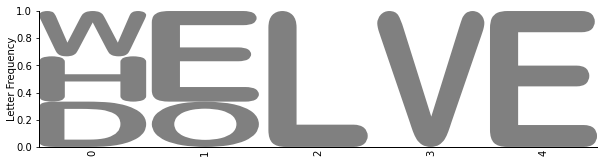

In [ ]:
we.play()

/Users/a233287/code/wordlexp/wordlexp.py:361: UserWarning: FixedFormatter should only be used together with FixedLocator
  def test():


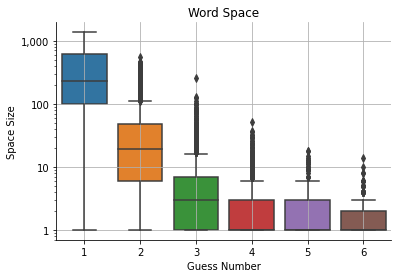

guess
1    230.0
2     19.0
3      3.0
4      1.0
5      1.0
6      1.0
Name: a_space, dtype: float64

/Users/a233287/code/wordlexp/wordlexp.py:370: UserWarning: FixedFormatter should only be used together with FixedLocator


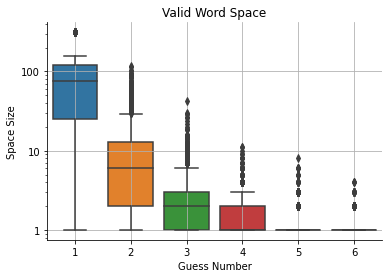

guess
1    75.0
2     6.0
3     2.0
4     1.0
5     1.0
6     1.0
Name: v_space, dtype: float64

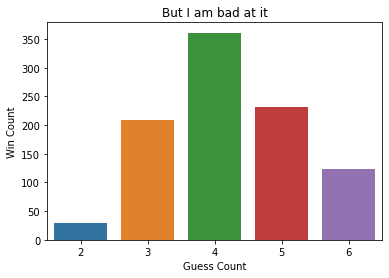

loss: 209 9.03%
speed: count    953.000000
mean       4.222455
std        1.025330
min        2.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        6.000000
Name: guess, dtype: float64


{'speed': 4.222455403987408, 'loss': 9.028077753779698}

In [166]:
we.evaluate_first_word('tails', plot=True)

In [110]:
import seaborn as sb
import matplotlib.pyplot as plt
import joblib
scores = joblib.load("candidate_scores.jl")
scores.set_index("word", inplace=True)
len(scores)

1566

speed


word
STEAL    4.164561
PLATE    4.165631
BLAST    4.166062
SLATE    4.166103
PLANT    4.171735
Name: speed, dtype: float64

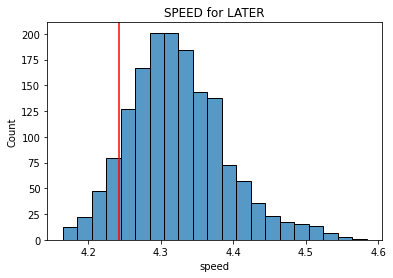

loss


word
SLEPT    7.156228
SPLAT    7.271418
PLANT    7.372210
STOMP    7.372210
CLAMP    7.401008
Name: loss, dtype: float64

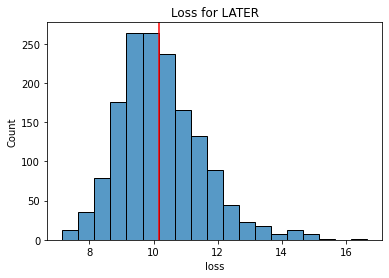

word
SLEPT    5.679022
SPLAT    5.735638
PLANT    5.771973
STOMP    5.826201
CLAMP    5.835077
Name: avg, dtype: float64

In [132]:
print('speed')
we.display(scores.sort_values('speed')['speed'].head())
p = sb.histplot(scores['speed'],binwidth=0.02)
p.set(title="SPEED for LATER")
plt.axvline(scores.loc['LATER']['speed'], color='red')
plt.savefig("imgs/speed_later.png")
plt.show()

print('loss')
we.display(scores.sort_values('loss')['loss'].head())
p = sb.histplot(scores['loss'],binwidth=.5)
p.set(title="Loss for LATER")
plt.axvline(scores.loc['LATER']['loss'], color='red')
plt.savefig("imgs/loss_later.png")
plt.show()
scores['avg'] = (scores['speed'] + scores['loss']) / 2
scores.sort_values('avg')['avg'].head()

,speed,loss,avg
word,,,
SLEPT,4.201816,7.156228,5.679022
SPLAT,4.199857,7.271418,5.735638
PLANT,4.171735,7.372210,5.771973
STOMP,4.280191,7.372210,5.826201
CLAMP,4.269146,7.401008,5.835077


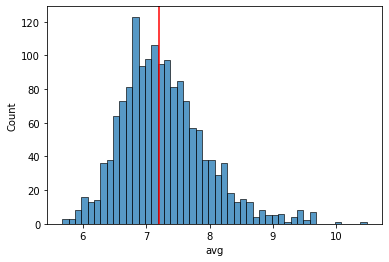

In [123]:
we.display(scores.sort_values('avg').head())
sb.histplot(scores['avg'],binwidth=0.1)
plt.axvline(scores.loc['LATER']['avg'], color='red')